# Self-contained Demos of AprilTag Usage

This Jupyter Notebook provides a complete guide to AprilTag recognition using computer vision techniques. It covers how to print an AprilTag, perform camera calibration with `OpenCV`, and detect tags in captured images. The notebook demonstrates how to retrieve each tag’s ID as well as its relative position and orientation using the `pupil-apriltags` library, enabling accurate spatial understanding from visual input.

## Requirements

1. This notebook requires the following files located in `src/ac_training_lab/apriltag_demo` for camera calibration. To download them, we use `git sparse-checkout` to clone only that specific directory from the repository:

In [1]:
!git clone --depth 1 --filter=blob:none --sparse https://github.com/AccelerationConsortium/ac-training-lab.git
%cd ac-training-lab
!git sparse-checkout set src/ac_training_lab/apriltag_demo

Cloning into 'ac-training-lab'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 75 (delta 1), reused 45 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 17.87 KiB | 1016.00 KiB/s, done.
Resolving deltas: 100% (1/1), done.
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 17 (delta 0), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 15.19 KiB | 3.80 MiB/s, done.
/content/ac-training-lab
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1/1), 83 bytes | 83.00 KiB/s, done.


2. This notebook uses the following Python libraries:

- `pupil-apriltags` — for AprilTag detection and pose estimation
- `opencv-python` — for camera calibration and image processing
- `numpy`, `matplotlib` — for math and visualization

In [2]:
import importlib
import sys

for pkg in ["pupil-apriltags", "opencv-python", "numpy", "matplotlib"]:
    try:
        importlib.import_module(pkg if pkg != "opencv-python" else "cv2")
    except ImportError:
        print(f"Installing {pkg} ...")
        get_ipython().run_line_magic('pip', f'install {pkg}')

Installing pupil-apriltags ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.2 MB/s eta 0:00:00


## Hardware Preparation

### 1. Print a Checkerboard Pattern

To calibrate your camera, you will need a printed checkerboard pattern. You can download a standard A4 checkerboard from [here](https://github.com/opencv/opencv/blob/master/doc/pattern.png) or [this PDF version](https://calib.io/pages/camera-calibration-pattern-generator). Print it out and attach it to a flat surface.


### 2. Get AprilTag Images
You can download an example AprilTag [here](https://github.com/AccelerationConsortium/ac-training-lab/tree/main/src/ac_training_lab/apriltag_demo/tag41_12_00110.pdf), or follow the steps below to generate a custom tag with your desired size and family. If you choose to use the example tag, you can jump to Camera Calibration


#### Select AprilTag images

You can find the images for the tags in the [apriltag-imgs repo](https://github.com/AprilRobotics/apriltag-imgs). For the vast majority of applications, the tagStandard41h12 family will be the correct choice. Scale up the images in your favorite editor and print them out or use the helper function below to automatically generate a printable SVG version of the tag at your desired size.

Some heuristics for when to choose other tag families:

1. If you need more tags, use tagStandard52h13
2. If you need to maximize the use of space on a small circular object, use tagCircle49h12 (or tagCircle21h7).
3. If you want to make a recursive tag use tagCustom48h12.
4. If you want compatibility with the ArUcO detector use tag36h11

If none of these fit your needs, generate your own custom tag family [here](https://github.com/AprilRobotics/apriltag-generation).

#### Get printable AprilTags

This is a helper function for generating a scalable SVG version of an AprilTag from a PNG image.

In [3]:
import os
import requests
from IPython.display import SVG, display

def generate_apriltag_svg(tag_name: str, tag_family: str = "tagStandard42h12", size_mm: int = 60):
    filename = f"{tag_name}.png"
    svg_filename = f"{tag_name}_{size_mm}mm.svg"
    png_url = f"https://raw.githubusercontent.com/AprilRobotics/apriltag-imgs/master/{tag_family}/{filename}"

    if not os.path.exists(filename):
        r = requests.get(png_url)
        if r.status_code == 200:
            with open(filename, "wb") as f:
                f.write(r.content)
        else:
            raise ValueError(f"Failed to download image. Status code: {r.status_code}")

    os.system(f"python tag_to_svg.py {filename} {svg_filename} --size={size_mm}mm")

    if os.path.exists(svg_filename):
        display(SVG(filename=svg_filename))
    else:
        raise FileNotFoundError(f"{svg_filename} not generated.")

To generate a printable SVG of an AprilTag, use the function below by specifying the full tag name (e.g., "tag41_12_00110") and its tag family (e.g., "tagStandard41h12").

In [ ]:
generate_apriltag_svg("tag41_12_00110", tag_family="tagStandard41h12")

You can convert the generated PDF file into a .png image and insert it into a document editor (e.g., Microsoft Word, Pages, or Google Docs) to adjust its printed size as needed.

## Camera Calibration

### 1. Camera Calibration Photo Guide

Camera calibration requires using the printed checkerboard and the camera you want to calibrate. Please follow the guidelines below when capturing images of the checkerboard:

- Use the same printed checkerboard for all photos.
- Capture at least 10 images, ideally 15–20, from different angles and distances.
- Make sure the checkerboard is fully visible and in focus in every image.
- Ensure that either the checkerboard or the camera remains fixed during the image capture process — only one of them should move
- Move and tilt the checkerboard to cover various positions in the frame (center, corners, edges).
- Vary the distance when taking photos — include close-up, mid-range, and far shots to improve calibration accuracy.
- Capture photos from different perspectives: front, top-down, angled from the sides.
- Ensure even lighting to avoid glare, shadows, or reflections.
- Place the checkerboard on a flat and rigid surface to avoid distortion.
- Save all images in a consistent format such as .jpg or .png, and ensure that all images have the same resolution.

After calibration, store all images in one folder.

### 2. Run Camera Calibration with Checkerboard Images

You should modify the following four parameters to calibrate your camera.  
Here is the explanation of each parameter:

- `rows`: the number of inner corners in the **vertical** direction.  
- `cols`: the number of inner corners in the **horizontal** direction.  
  > Note: These refer to the number of **corner intersections**, not the number of squares.

- `size`: the length of one square on the checkerboard, in **millimeters**.  
- `image_dir`: the path to the folder that contains your calibration images.


In [5]:
rows = 6
cols = 9
size = 23
image_dir = 'src/ac_training_lab/apriltag_demo/checkerboard_images'

Now run the script to calibrate your camera. It will automatically process all images in the given directory using the specified checkerboard settings.

In [ ]:
import os

image_paths = [
    os.path.join(image_dir, f)
    for f in sorted(os.listdir(image_dir))
    if f.lower().endswith(('.jpg', '.png'))
]

args = f"-r {rows} -c {cols} -s {size} -d " + ' '.join(f'"{path}"' for path in image_paths)

cmd = f"calibrate_camera.py {args}"
print(">> run:\n%run", cmd)

get_ipython().run_line_magic("run", cmd)
camera_params = np.load("camera_params.npy")


## AprilTag Detection


You should modify the following three parameters to recongnize the apriltag.  
Here is the explanation of each parameter:
- `apriltag_path`: the path to the image containing the AprilTag
- `families`: the tag family the AprilTag belongs to (e.g., `tag16h5`, `tagStandard41h12`, `tag36h11`, etc.).
- `tagsize`: The size of the tag in centimeters. Each tag design has a black border and a white border, but some designs have the white border on the inside and some have the black border on the inside. The tagsize is thus measured from where the two borders meet, see the figure below for an example.

> Note: The tag size should not be measured from the outside of the tag. The tag size is defined as the distance between the detection corners, or alternately, the length of the edge between the white border and the black border. The following illustration marks the detection corners with red Xs and the tag size with a red arrow for a tag from the 48h12Custom tag family.

<p align="center">
  <img src="https://raw.githubusercontent.com/AprilRobotics/apriltag/master/tag_size_48h12.png" alt="AprilTag Example" width="400">
</p>

In [ ]:
apriltag_path = 'src/ac_training_lab/apriltag_demo/apriltag_images/apriltag_test.jpg'
families = "tagStandard41h12"
tagsize = 4.5

Now, run the following code to recognize the AprilTag.

Found 1 tags

Tag ID: 110
  Center: [614.0852433 339.5371153]
  Corners: [[555.03686523 399.08496094]
 [673.36199951 398.90393066]
 [672.22766113 280.90289307]
 [554.46936035 279.83065796]]
  Translation (x, y, z): [ 1.16738126 -1.50948291 36.79969538]
  Distance from camera: 36.85 meters
  Roll: -2.83°, Pitch: -4.92°, Yaw: -0.03°


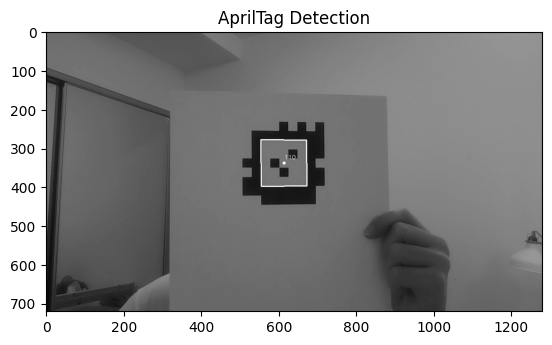

In [ ]:
import cv2
import numpy as np
from pupil_apriltags import Detector
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

image = cv2.imread(apriltag_path, cv2.IMREAD_GRAYSCALE)

at_detector = Detector(
    families=families,
    nthreads=1,
    quad_decimate=1.0,
    quad_sigma=0.0,
    refine_edges=1,
    decode_sharpening=0.25,
    debug=0
)

detections = at_detector.detect(
    image,
    estimate_tag_pose=True,
    camera_params=camera_params,
    tag_size=tagsize
)

print(f"Found {len(detections)} tags")

for det in detections:
    tag_id = det.tag_id
    center = det.center
    corners = det.corners.astype(int)

    cv2.polylines(image, [corners], True, 255, 2)
    cx, cy = map(int, center)
    cv2.circle(image, (cx, cy), 4, 255, -1)
    cv2.putText(image, str(tag_id), (cx, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)

    print(f"\nTag ID: {tag_id}")
    print(f"  Center: {center}")
    print(f"  Corners: {det.corners}")

    if det.pose_t is not None:
        t = det.pose_t.flatten()
        print(f"  Translation (x, y, z): {t}")
        print(f"  Distance from camera: {np.linalg.norm(t):.2f} meters")

        euler = R.from_matrix(det.pose_R).as_euler('xyz', degrees=True)
        roll, pitch, yaw = euler
        print(f"  Roll: {roll:.2f}°, Pitch: {pitch:.2f}°, Yaw: {yaw:.2f}°")
    else:
        print("No pose estimated (pose_t is None)")

plt.imshow(image, cmap='gray')
plt.title("AprilTag Detection")
plt.show()



### Output Field Explanation

- **Tag ID**: The unique identifier of the detected AprilTag.

- **Center**: The (x, y) pixel coordinates of the tag's center in the image.

- **Corners**: The pixel coordinates of the tag’s four corners, typically ordered counterclockwise.

The camera coordinate system follows OpenCV's default convention:

- x-axis: right  
- y-axis: down  
- z-axis: forward (into the scene)

- **Translation (x, y, z)**: The tag’s 3D position relative to the camera, in centimeters:
  - x: horizontal offset (left/right)
  - y: vertical offset (up/down)
  - z: distance from the camera (depth)

- **Distance from camera**: The Euclidean distance between the camera and the tag’s center in 3D space.

- **Roll, Pitch, Yaw**: The tag’s rotation angles relative to the camera, in degrees:
  - Roll: rotation around the x-axis
  - Pitch: rotation around the y-axis
  - Yaw: rotation around the z-axis
